# Import libraries 

In [1]:
# Jax dedicated libraries
from flax import nnx
import optax
import jax
import jax.numpy as jnp # From this point on, there should not be numpy anymore but only jax.numpy
import jax.scipy as jsp

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import corner
import numpy as np

# Module functions
import ximinf.nn_train as nntr
import ximinf.nn_test as nnte
import ximinf.generate_sim as gsim

# Other
import h5py
import gc

from absl import logging

logging.set_verbosity(logging.ERROR)

# Set seed

In [2]:
key = jax.random.PRNGKey(42)

W0000 00:00:1770213046.928014 60765632 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1770213046.971760 60765632 service.cc:145] XLA service 0x7ff441585250 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770213046.971791 60765632 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1770213046.976849 60765632 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1770213046.976875 60765632 mps_client.cc:384] XLA backend will use up to 22906077184 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



# Set device type

In [3]:
# Try GPU backends in priority order
gpu = None
for backend in ("METAL", "cuda", "gpu"):
    try:
        devs = jax.devices(backend)
    except RuntimeError:
        continue
    if devs:
        gpu = devs[0]
        break

# Fallback
cpu = jax.devices("cpu")[0]

# Use GPU if found
if gpu=='cuda':
    nntr.print_gpu_memory()
    device = gpu 
elif gpu is not None:
    device = gpu
else:
    device = cpu
    
jax.default_device(device)
    

backend = jax.default_backend()
print(backend)

METAL


# Import training data

In [4]:
# Path to the new HDF5 file
file_path = "./data/SIM/simulations_new_priors_1000_3_brok_alpha_beta_gamma_sigma_XS.h5"

with h5py.File(file_path, "r") as f:
    # Parameters: load directly as (N,) JAX arrays
    params = {key: jnp.array(f[f"params/{key}"][:]) for key in f["params"].keys()}

    # Data columns: load directly as (N, M) JAX arrays
    data = {col: jnp.array(f[f"data/{col}"][:]) for col in f["data"].keys()}

# Number of simulations and SNe per simulation
N = next(iter(params.values())).shape[0]   # N simulations
M = next(iter(data.values())).shape[1]     # M SNe per simulation

print(f"The file contains {N} simulations of size {M}")

gc.collect()

The file contains 3000 simulations of size 100


325

In [5]:
# Example usage
print("Parameter names:", list(params.keys()))
param_groups = ['mabs', 'beta', ['alpha_low', 'alpha_high'], ['gamma', 'sigma_int']] # Sort them from easiest to hardest to infer
print(param_groups[0])

# ----------------------------
# Flatten param_groups into a unique ordered list
# ----------------------------
global_param_names = []
for group in param_groups:
    group_list = [group] if isinstance(group, str) else group
    for p in group_list:
        if p not in global_param_names:
            global_param_names.append(p)

Parameter names: ['alpha_high', 'alpha_low', 'beta', 'gamma', 'mabs', 'sigma_int']
mabs


In [6]:
print("Column names:", list(data.keys()))

Column names: ['c', 'c_err', 'localcolor', 'localcolor_err', 'magobs', 'magobs_err', 'x1', 'x1_err', 'z']


# Compute residuals

In [7]:
magobs = data["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

# Take care to not run the correction twice
mu_planck18, data['magobs']= nntr.rm_cosmo(data['z'], data['magobs'])

# Only update 'mabs' if it exists in params
if 'mabs' in params:
    params['mabs'] = params['mabs'] + 19.3

gc.collect()

0

## Apply mask

In [8]:
# Masked version (NaNs)
data_filt = {k: jnp.where(mask, v, jnp.nan) for k, v in data.items()}

## Display residuals

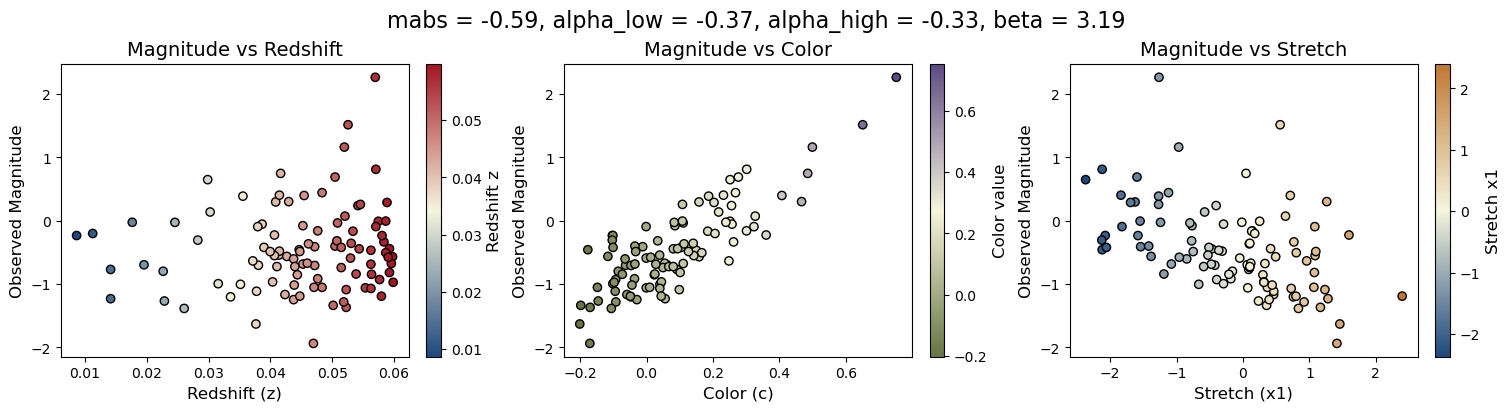

27

In [9]:
index = 9  # index for your data slice

# Define the color maps
cmap1 = LinearSegmentedColormap.from_list(
    'custom_red_beige_blue',
    ['#1F487E', 'beige', '#A31621']
)

cmap2 = LinearSegmentedColormap.from_list(
    'custom_green_beige_purple',
    ['#687444', 'beige', '#5E4983']
)

cmap3 = LinearSegmentedColormap.from_list(
    'custom_blue_beige_orange',
    ['#1F487E', 'beige', '#C07835']
)

# Create figure and horizontal subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# First subplot: z vs magobs
sc1 = axes[0].scatter(
    data_filt['z'][index, :],
    data_filt['magobs'][index, :],
    c=data_filt['z'][index, :],
    cmap=cmap1,
    edgecolor='k'
)
axes[0].set_title('Magnitude vs Redshift', fontsize=14)
axes[0].set_xlabel('Redshift (z)', fontsize=12)
axes[0].set_ylabel('Observed Magnitude', fontsize=12)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('Redshift z', fontsize=12)

# Second subplot: c vs magobs
sc2 = axes[1].scatter(
    data_filt['c'][index, :],
    data_filt['magobs'][index, :],
    c=data_filt['c'][index, :],
    cmap=cmap2,
    edgecolor='k'
)
axes[1].set_title('Magnitude vs Color', fontsize=14)
axes[1].set_xlabel('Color (c)', fontsize=12)
axes[1].set_ylabel('Observed Magnitude', fontsize=12)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Color value', fontsize=12)

# Third subplot: x1 vs magobs
sc3 = axes[2].scatter(
    data_filt['x1'][index, :],
    data_filt['magobs'][index, :],
    c=data_filt['x1'][index, :],
    cmap=cmap3,
    edgecolor='k'
)
axes[2].set_title('Magnitude vs Stretch', fontsize=14)
axes[2].set_xlabel('Stretch (x1)', fontsize=12)
axes[2].set_ylabel('Observed Magnitude', fontsize=12)
cbar3 = plt.colorbar(sc3, ax=axes[2])
cbar3.set_label('Stretch x1', fontsize=12)

fig.suptitle(
    (
        f"mabs = {params['mabs'][index]:.2f}, "
        f"alpha_low = {params['alpha_low'][index]:.2f}, alpha_high = {params['alpha_high'][index]:.2f}, "
        f"beta = {params['beta'][index]:.2f}"
    ),
    fontsize=16
)

plt.show()

gc.collect() 


In [10]:
# Padded version (zeros)
data_padded = {k: jnp.where(mask, v, 0) for k, v in data.items()}

# select_columns = ['magobs', 'magobs_err', 'c', 'c_err', 'x1','x1_err', 'mass', 'mass_err', 'localcolor', 'localcolor_err', 'prompt']
select_columns = ['magobs', 'magobs_err', 'c', 'c_err', 'x1','x1_err', 'localcolor', 'localcolor_err'] #
select_params  = list(params.keys())  # or subset you want

data_stats = {}
for col in select_columns:
    # flatten over all objects in all examples
    all_values = jnp.concatenate([data[col].ravel() for data in [data]])  # replace with training set list if needed
    mu = jnp.mean(all_values)
    sigma = jnp.std(all_values) + 1e-8
    data_stats[col] = {'mu': mu, 'sigma': sigma}

data_padded_normed = {}
for col in select_columns:
    x = data_padded[col]
    mu = data_stats[col]['mu']
    sigma = data_stats[col]['sigma']
    x_norm = (x - mu) / sigma
    x_norm = jnp.where(mask, x_norm, 0.0)
    data_padded_normed[col] = x_norm

data_padded = data_padded_normed
gc.collect()

0

In [11]:
param_stats = {}
for dic_key in select_params:
    all_values = jnp.concatenate([params[dic_key].ravel() for params in [params]])  # replace with training set list
    mu = jnp.mean(all_values)
    sigma = jnp.std(all_values) + 1e-8
    param_stats[dic_key] = {'mu': mu, 'sigma': sigma}

bounds_phys = {
    name: {
        'min': float(jnp.round(jnp.min(values), 1)),
        'max': float(jnp.round(jnp.max(values), 1))
    }
    for name, values in params.items()
}

gc.collect()

0

In [12]:
# data   = nntr.normalize(data, data_stats)
params = nntr.normalize(params, param_stats)

gc.collect()

0

# Prepare train and test sets

## Set bounds

In [16]:
bounds = {
    name: {
        'min': float(jnp.round(jnp.min(values), 1)),
        'max': float(jnp.round(jnp.max(values), 1))
    }
    for name, values in params.items()
}

# ----------------------------
# Parameter bounds (global ordering)
# ----------------------------
BOUNDS = jnp.array([
    [bounds[p]['min'], bounds[p]['max']]
    for p in global_param_names
])

ranges = {
    name: (b['min'], b['max'])
    for name, b in bounds.items()
}

## Label data

In [19]:
# -----------------------------------------
# Autoregressive dataset construction
# -----------------------------------------

param_names = list(params.keys())
K = len(param_names)  # total number of parameters

# Convert bounds
mins = jnp.array([bounds[name]['min'] for name in param_names])
maxs = jnp.array([bounds[name]['max'] for name in param_names])

false_params = gsim.scan_params(ranges, N)
false_params = jnp.stack(
    [false_params[name] for name in param_names],
    axis=1,   # (N, K)
)

# True params in array form
param_true = jnp.stack([params[name] for name in param_names], axis=1)  # (N,K)

# ----- Observational data concatenation (unchanged) -----
data_names = list(data_padded.keys())
n_cols = len(data_names)

data_arrays = [data_padded[name] for name in data_names]
data_stacked = jnp.stack(data_arrays, axis=-1)  # (N, M, n_cols)
data_concat  = data_stacked.reshape(N, M * n_cols)

gc.collect()

1364

## Prepare train/test sets

In [20]:
# ----------------------------------------------------
# Global train / test split (shared across all groups)
# ----------------------------------------------------

key, split_key = jax.random.split(key)

indices = jnp.arange(N)
perm = jax.random.permutation(split_key, indices)

n_test = int(0.3 * N)
test_idx  = perm[:n_test]
train_idx = perm[n_test:]

# Slice once
data_train  = data_concat[train_idx]
data_test   = data_concat[test_idx]

param_true_train  = param_true[train_idx]
param_true_test   = param_true[test_idx]

false_params_train = false_params[train_idx]
false_params_test  = false_params[test_idx]

mask_train = mask[train_idx]
mask_test  = mask[test_idx]

gc.collect()

0

## Concatenate data

In [21]:
# ----------------------------------------------------
# Build parameter slices per group (correct semantics)
# ----------------------------------------------------

all_group_param_slices = []

for g, group in enumerate(param_groups):

    group_list = [group] if isinstance(group, str) else group
    group_idx = jnp.array([param_names.index(name) for name in group_list])

    prev_groups = [
        p for i in range(g)
        for p in (param_groups[i] if isinstance(param_groups[i], list) else [param_groups[i]])
    ]
    prev_idx = (
        jnp.array([param_names.index(name) for name in prev_groups], dtype=int)
        if prev_groups else jnp.array([], dtype=int)
    )

    visible_idx = (
        jnp.concatenate([prev_idx, group_idx], axis=0)
        if prev_idx.size > 0 else group_idx
    )

    # --------------------
    # Labels
    # --------------------
    key, label_key1, label_key2 = jax.random.split(key,3)
    labels_train = jax.random.uniform(label_key1, (train_idx.shape[0],)) > 0.5
    labels_test  = jax.random.uniform(label_key2, (test_idx.shape[0],))  > 0.5

    # --------------------
    # Build params (ONLY flip current group)
    # --------------------
    params_train = jnp.array(param_true_train)
    params_train = params_train.at[:, group_idx].set(
        jnp.where(
            labels_train[:, None],
            param_true_train[:, group_idx],
            false_params_train[:, group_idx],
        )
    )

    params_test = jnp.array(param_true_test)
    params_test = params_test.at[:, group_idx].set(
        jnp.where(
            labels_test[:, None],
            param_true_test[:, group_idx],
            false_params_test[:, group_idx],
        )
    )

    chosen_train = params_train[:, visible_idx]
    chosen_test  = params_test[:,  visible_idx]

    all_group_param_slices.append({
        "chosen_train": chosen_train,
        "chosen_test":  chosen_test,
        "labels_train": labels_train,
        "labels_test":  labels_test,
    })


# Build a neural network

In [22]:
# Define the size of the different network layers
Nsize_p = 16 #64 
Nsize_r = 32 #256 

n_cols = len(data_names)
print('# of columns :', n_cols)
n_params = len(param_names)
print('# of params :', n_params)


# of columns : 8
# of params : 6


In [23]:
# ----------------------------
# Prepare a list of models, one per group
# ----------------------------

models_per_group = []
group_configs = []
rng = nnx.Rngs(0)

for g, group in enumerate(param_groups):
    # Determine number of parameters visible for this group
    prev_groups = [
        p
        for i in range(g)
        for p in (param_groups[i] if isinstance(param_groups[i], list) else [param_groups[i]])
    ]
    group_list = [group] if isinstance(group, str) else group
    visible_param_names = prev_groups + group_list
    n_params_visible = len(visible_param_names)

    print(
        f"Group {g}: visible parameters = {visible_param_names}, "
        f"total = {n_params_visible}"
    )

    # Create DeepSetClassifier for this group
    model_g = nntr.DeepSetClassifier(
        dropout_rate=0.2,
        Nsize_p=Nsize_p,
        Nsize_r=Nsize_r,
        n_cols=n_cols,
        n_params=n_params_visible,
        rngs=rng,
    )

    models_per_group.append(model_g)

    # ---- CONFIG CAPTURE ----
    group_configs.append({
        "group_id": g,
        "n_params_visible": n_params_visible,
        "visible_param_names": visible_param_names,
    })


            
model_config = {
    "shared": {
        "Nsize_p": Nsize_p,
        "Nsize_r": Nsize_r,
        "n_cols": n_cols,
        "param_groups": param_groups,
        "global_param_names": global_param_names,
        "bounds": bounds_phys,
        "bounds_norm": bounds,
        "param_stats": param_stats,
        "data_stats": data_stats
    },
    "groups": group_configs,
}

# Optional: visualize one model
nnx.display(models_per_group[0])


Group 0: visible parameters = ['mabs'], total = 1
Group 1: visible parameters = ['mabs', 'beta'], total = 2
Group 2: visible parameters = ['mabs', 'beta', 'alpha_low', 'alpha_high'], total = 4
Group 3: visible parameters = ['mabs', 'beta', 'alpha_low', 'alpha_high', 'gamma', 'sigma_int'], total = 6


# Train NN

=== Training model for group 3: ['gamma', 'sigma_int'] ===


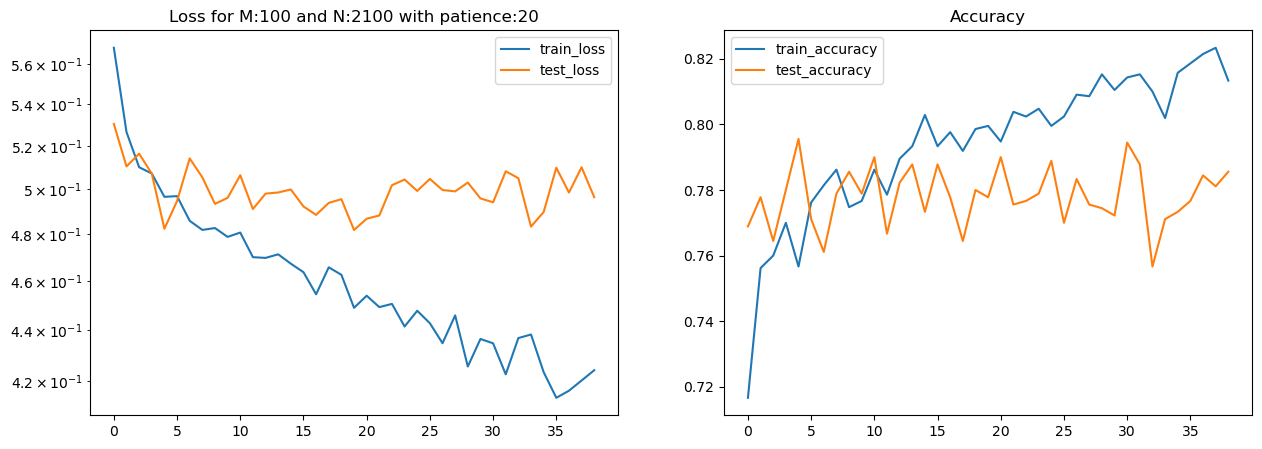


 Early stopping at epoch 40 (accuracy >= 0.7 and 20 strikes) 



In [24]:
# Early stopping parameters
n_batch = 100
patience = 20 #40
epochs = 1000

metrics_histories = []

# init_values = jnp.linspace(3e-4, 3e-4, len(all_group_param_slices))
# patiences   = jnp.linspace(40, 20,  len(all_group_param_slices))
# epochss = [1,1,1,1000]
init_values = [1e-3, 1e-3, 1e-3, 1e-3]

for g, group_data in enumerate(all_group_param_slices):

    print(f"\n=== Training model for group {g}: {param_groups[g]} ===")

    chosen_train = group_data["chosen_train"]
    chosen_test  = group_data["chosen_test"]
    labels_train = group_data["labels_train"]
    labels_test  = group_data["labels_test"]

    # ------------------------------------------------
    # Concatenate inputs (no parameter logic here)
    # ------------------------------------------------
    train_data = jnp.concatenate(
        [data_train, mask_train, chosen_train], axis=-1
    )
    test_data = jnp.concatenate(
        [data_test, mask_test, chosen_test], axis=-1
    )

    train_labels = labels_train.astype(jnp.int32)[:, None]
    test_labels  = labels_test.astype(jnp.int32)[:, None]

    train_data   = jax.device_put(train_data, cpu)
    train_labels = jax.device_put(train_labels, cpu)
    test_data    = jax.device_put(test_data, cpu)
    test_labels  = jax.device_put(test_labels, cpu)

    # ------------------------------------------------
    # Optimiser
    # ------------------------------------------------
    learning_rate_schedule = optax.exponential_decay(
        init_value=init_values[g],
        transition_steps=1000,
        decay_rate=0.9,
    )

    optimizer = nnx.Optimizer(
        models_per_group[g],
        optax.adamw(learning_rate_schedule, 0.9),
    )

    batch_size = train_data.shape[0] // n_batch

    model_g, metrics_history, key = nntr.train_loop(
        model=models_per_group[g],
        optimizer=optimizer,
        train_data=train_data,
        train_labels=train_labels,
        test_data=test_data,
        test_labels=test_labels,
        key=key,
        epochs=epochs, #epochs #epochss[g]
        batch_size=batch_size,
        patience=patience,
        metrics_history={
            'train_loss': [],
            'train_accuracy': [],
            'test_loss': [],
            'test_accuracy': []
        },
        M=M,
        N=int(N * 0.7),
        cpu=cpu,
        gpu=gpu,
        group_id=g,
        group_params=param_groups[g],
        plot_flag=True,
    )
    
    models_per_group[g] = model_g
    metrics_histories.append(metrics_history)


# Test NN

## Test Accuracy

In [25]:
# Set models to evaluation mode
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

batch_size = 128
metrics_per_group = []

# Loop over groups
for g, model_g in enumerate(models_per_group):

    print(f"\n=== Evaluating model for group {g}: {param_groups[g]} ===")

    chosen_test  = all_group_param_slices[g]["chosen_test"]
    labels_test  = all_group_param_slices[g]["labels_test"]

    num_samples = labels_test.shape[0]

    all_logits = []
    all_labels = []

    for i in range(0, num_samples, batch_size):

        xb = jnp.concatenate(
            [
                data_test[i:i + batch_size],
                mask_test[i:i + batch_size],
                chosen_test[i:i + batch_size],
            ],
            axis=-1,
        )

        yb = labels_test[i:i + batch_size, None].astype(jnp.int32)

        # Model predictions
        logits = nntr.pred_step(model_g, xb)
        all_logits.append(logits)
        all_labels.append(yb)

    # Merge batches
    all_logits = jnp.concatenate(all_logits, axis=0)
    all_labels = jnp.concatenate(all_labels, axis=0)

    all_preds = (jsp.special.expit(all_logits) > 0.5).astype(jnp.int32)

    # Confusion matrix components
    TP = jnp.sum((all_preds == 1) & (all_labels == 1))
    TN = jnp.sum((all_preds == 0) & (all_labels == 0))
    FP = jnp.sum((all_preds == 1) & (all_labels == 0))
    FN = jnp.sum((all_preds == 0) & (all_labels == 1))

    accuracy    = (TP + TN) / (TP + TN + FP + FN)
    precision   = TP / (TP + FP + 1e-8)
    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    print(
        f"Group {g} ({param_groups[g]}): "
        f"Accuracy={accuracy:.3f}, "
        f"Precision={precision:.3f}, "
        f"Sensitivity={sensitivity:.3f}, "
        f"Specificity={specificity:.3f}"
    )

    metrics_per_group.append({
        "accuracy": accuracy,
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
    })



=== Evaluating model for group 0: mabs ===
Group 0 (mabs): Accuracy=0.959, Precision=0.928, Sensitivity=0.991, Specificity=0.929

=== Evaluating model for group 1: beta ===
Group 1 (beta): Accuracy=0.806, Precision=0.731, Sensitivity=0.942, Specificity=0.679

=== Evaluating model for group 2: ['alpha_low', 'alpha_high'] ===
Group 2 (['alpha_low', 'alpha_high']): Accuracy=0.910, Precision=0.915, Sensitivity=0.900, Specificity=0.919

=== Evaluating model for group 3: ['gamma', 'sigma_int'] ===
Group 3 (['gamma', 'sigma_int']): Accuracy=0.777, Precision=0.751, Sensitivity=0.853, Specificity=0.694


# Test posterior

In [26]:
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

# ----------------------------
# Parameter info
# ----------------------------
param_names = list(bounds.keys())
N_SIM_PARAMS = len(param_names)

# ----------------------------
# LAST GROUP: precomputed params + labels
# ----------------------------
chosen_test = all_group_param_slices[-1]["chosen_test"]
labels_test = all_group_param_slices[-1]["labels_test"]

# ----------------------------
# Mask for "true" samples (label == 1)
# ----------------------------
mask_true = labels_test == 1
N_sims = int(jnp.minimum(100, jnp.sum(mask_true)))

# Get indices of true samples
true_idx = jnp.nonzero(mask_true, size=N_sims, fill_value=0)[0]

NDIM = len(global_param_names)

# ----------------------------
# Construct test inputs and full theta
# ----------------------------
# visible parameters for true samples
theta_star = chosen_test[true_idx]

# inputs excluding theta (data + mask)
xy_test = jnp.concatenate(
    [data_test[true_idx, :], mask_test[true_idx, :]],
    axis=-1
)

alpha_grid = jnp.linspace(0, 1, 50)

In [34]:
index = 38

# Convert theta_star to dict for unnormalisation
theta_star_dict = {name: theta_star[index, i] for i, name in enumerate(global_param_names)}

# Unnormalize
theta_star_unnormed_dict = nntr.unnormalize(theta_star_dict, param_stats)

# Convert back to array in the same order as global_param_names
theta_star_unnormed = jnp.array([theta_star_unnormed_dict[name] for name in global_param_names])

print(param_groups)
print(theta_star_unnormed)

['mabs', 'beta', ['alpha_low', 'alpha_high'], ['gamma', 'sigma_int']]
[-0.8991852   3.416127   -0.15121585 -0.15788853  0.23477645  0.12117954]


In [37]:
# Select a single test sample (or batch) as input
test_data = xy_test[index, :]  # single sample, shape (n_features,)

# Initial position at the middle of priors
theta_init = theta_star[index,:] #(BOUNDS[:, 0] + BOUNDS[:, 1]) / 2.0

visible_indices, group_indices = nnte.preprocess_groups(param_groups, global_param_names)

def log_post(theta):
    # Use the new grouped log-prob function
    return nnte.log_prob_fn_groups(
        theta,
        models_per_group,  # list of models per group
        test_data,
        BOUNDS,
        visible_indices,
        group_indices
    )

# Run MCMC
print("Launch MCMC ...")
key, post = nnte.sample_posterior(
    log_post,
    n_warmup=100,
    n_samples=100,
    init_position=theta_init,
    rng_key=key
)
print("...finished")


Launch MCMC ...


XlaRuntimeError: UNKNOWN: /Users/atrigui/miniconda3/envs/sbi_conda/lib/python3.12/site-packages/ximinf/nn_test.py:93:32: error: failed to legalize operation 'mhlo.popcnt'
    (warmup_state, params), _ = warmup.run(warmup_key, init_position, num_steps=n_warmup)
                               ^
/Users/atrigui/miniconda3/envs/sbi_conda/lib/python3.12/site-packages/ximinf/nn_test.py:93:32: note: called from
    (warmup_state, params), _ = warmup.run(warmup_key, init_position, num_steps=n_warmup)
                               ^
/Users/atrigui/miniconda3/envs/sbi_conda/lib/python3.12/site-packages/ximinf/nn_test.py:100:36: note: called from
    rng_key, kernel, warmup_state = build_kernel(log_prob, init_position, n_warmup, rng_key)
                                   ^
/var/folders/98/9tmsfpws669458831tkwxxbr0000gp/T/ipykernel_98419/2145490446.py:22:12: note: called from
<frozen runpy>:88:4: note: called from
<frozen runpy>:198:11: note: called from
/Users/atrigui/miniconda3/envs/sbi_conda/lib/python3.12/site-packages/ximinf/nn_test.py:93:32: note: see current operation: %8436 = "mhlo.popcnt"(%8435) : (tensor<si32>) -> tensor<si32>
    (warmup_state, params), _ = warmup.run(warmup_key, init_position, num_steps=n_warmup)
                               ^


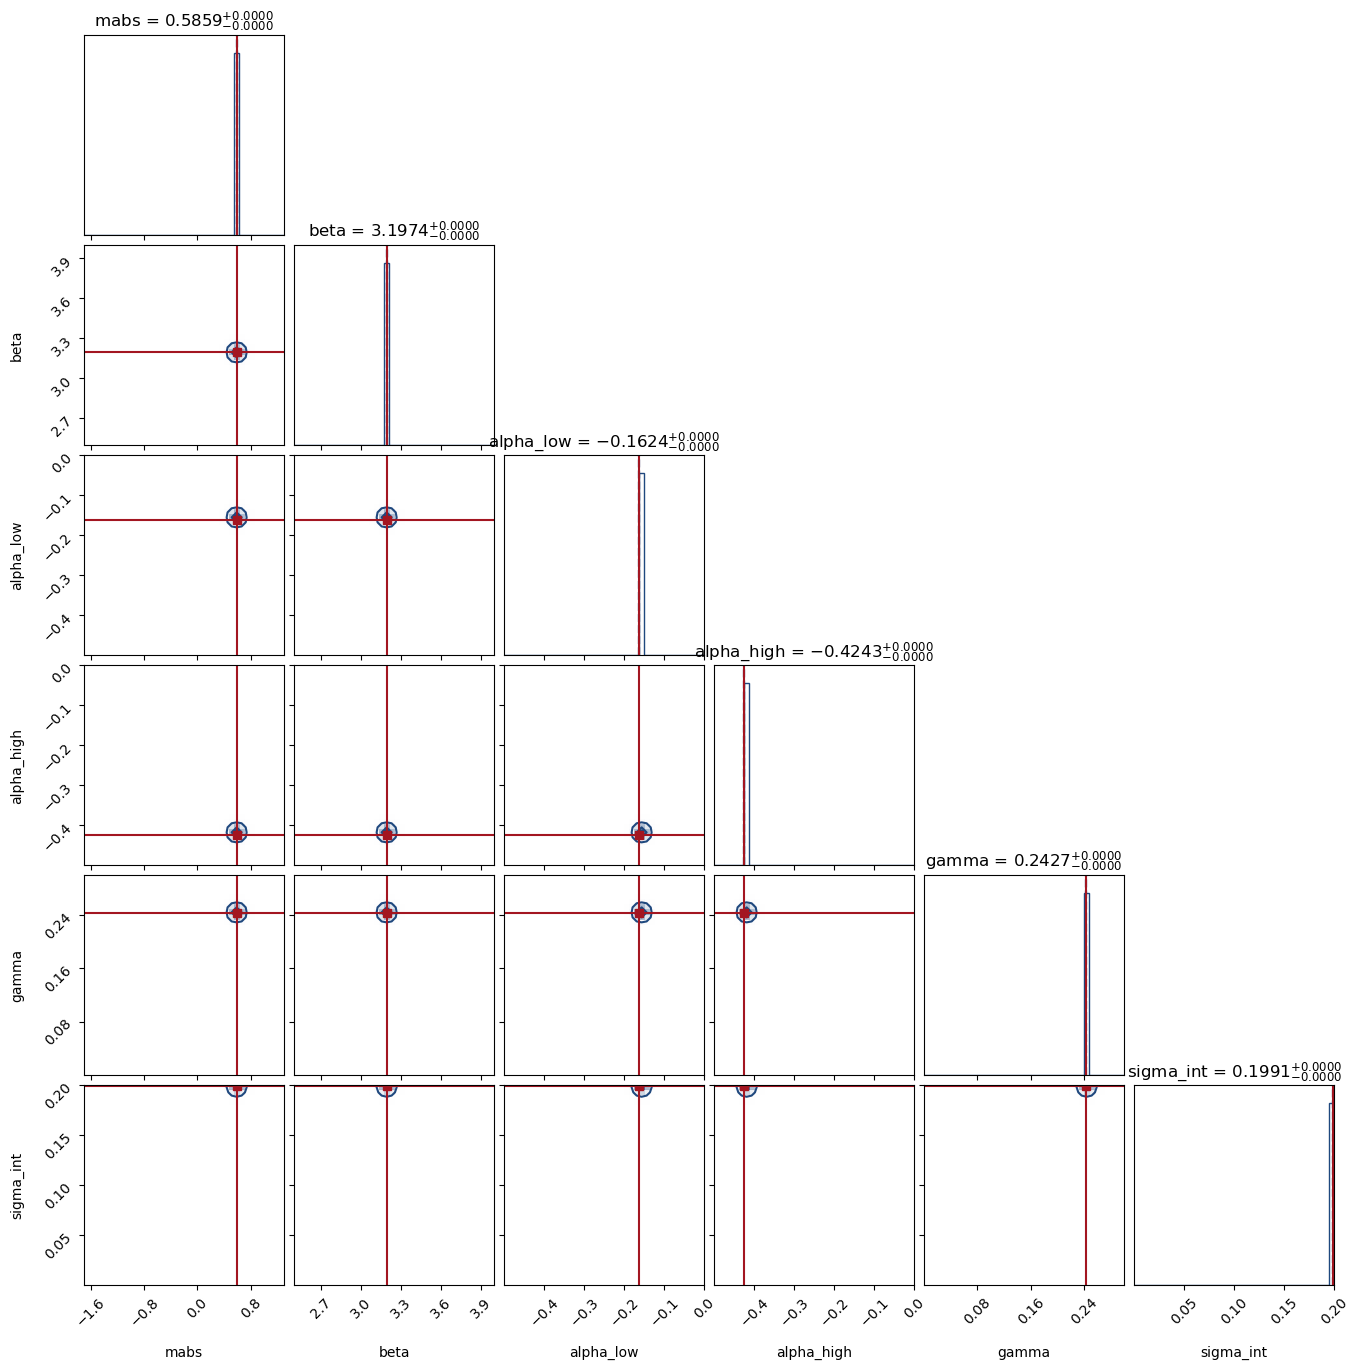

In [49]:
n_samples, n_params = post.shape

BOUNDS_phys = jnp.array([
    [bounds_phys[p]['min'], bounds_phys[p]['max']]
    for p in global_param_names
])

# Convert post from array to dict with column names
post_dict = {name: post[:, i] for i, name in enumerate(global_param_names)}

# Unnormalize each parameter
post_unnormed_dict = nntr.unnormalize(post_dict, param_stats)

# Convert back to array for plotting
post_unnormed = jnp.stack([post_unnormed_dict[name] for name in global_param_names], axis=1)

# Now post_unnormed[:, i] contains the real-scale parameters
x = post_unnormed[:, 0]

fig = corner.corner(
    np.array(post_unnormed),
    labels=global_param_names,
    range=[tuple(b) for b in BOUNDS_phys],
    quantiles=[0.16, 0.5, 0.84],      # 1D marginal: 1σ
    levels=[0.393469, 0.864665],     # 2D contours: 1σ, 2σ
    show_titles=True,
    title_fmt=".4f",
    bins=40,
    smooth=1.0,
    color="#1F487E",
    truths=theta_star_unnormed[:],
    truth_color="#A31621", 
    truth_alpha=0.8
)

plt.savefig("./corner.png",dpi=150)
plt.show()

# Save NN to disk

In [39]:
# Save the trained model for future use
save_path = './data/NNs/nn_model_mac_m1_M100_z_0_06'
nntr.save_autoregressive_nn(models_per_group,save_path, model_config)
print('NNs saved to ' + save_path)

NNs saved to ./data/NNs/nn_model_mac_m1_M100_z_0_06
